In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import ast
from glob import glob

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
train_files = glob("../input/train_simplified/*.csv")

# Any results you write to the current directory are saved as output.

['test_simplified.csv', 'sample_submission.csv', 'train_simplified', 'test_raw.csv']


In [3]:
# Reading test file
test = pd.read_csv('../input/test_simplified.csv', index_col="key_id")
test.head()
testidx = test.index

In [6]:
# Configuration for data

# Width/Height (images are squares) of each image
IMAGE_SIZE = 32

# Total number of classes of the given problem 
NUM_CLASSES = 340

# Total number of instances used for train or validation tests
NUM_ROWS_TOTAL = 49707919//20000
NUM_ROWS_TOTAL -= (NUM_ROWS_TOTAL % NUM_CLASSES)

# How many lines of the input file must be readed, at a maximum, each iteration
CHUNKSIZE = 1024

# Number of instances of each class
EACH_SET_SIZE = NUM_ROWS_TOTAL // NUM_CLASSES

In [7]:
from PIL import Image, ImageDraw
from dask import bag

# Rasterizarion algorithm from https://www.kaggle.com/jpmiller/image-based-cnn#
def draw_it(strokes, imheight=32, imwidth=32):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

In [8]:
# Rasterizing vector images of test set
imagebag = bag.from_sequence(test.drawing.values).map(draw_it, 
                                                      imheight=IMAGE_SIZE, 
                                                      imwidth=IMAGE_SIZE)

test_X = np.array(imagebag.compute())

In [9]:
# Reshape test set
test_X = test_X.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
test_X.shape

(112199, 32, 32, 1)

In [10]:
# Allocate heavy RAM memory for all train data images & classes at one shot
# in order to speed up the processing
raster_array = np.zeros((NUM_ROWS_TOTAL, IMAGE_SIZE, IMAGE_SIZE, 1))
classes = pd.Series([None] * NUM_ROWS_TOTAL)

In [12]:
# Reading and rasterizing on-demand, to save memory
i = 0
for f in train_files:
    for df in pd.read_csv(f, index_col="key_id", chunksize=CHUNKSIZE, nrows=EACH_SET_SIZE):
        imagebag = bag.from_sequence(df.drawing.values).map(draw_it, imheight=IMAGE_SIZE, imwidth=IMAGE_SIZE)
        imagebag = np.array(imagebag.compute())
        classes[i:(i + imagebag.shape[0])] = df["word"].replace("\s+", "_", regex=True)
        raster_array[i:(i + imagebag.shape[0])] = imagebag.reshape((*imagebag.shape, 1))
        i += imagebag.shape[0]


In [13]:
# Shuffle raster_array and classes in unison
import numpy.core.defchararray as np_f

def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

classes = classes.values
shuffle_in_unison(raster_array, classes)

array(['helicopter', 'cloud', 'campfire', ..., 'cat', 'basketball',
       'washing_machine'], dtype=object)

In [15]:
# Get class dummies
dummies = pd.get_dummies(classes)
dummies.head(n=10)

,The_Eiffel_Tower,The_Great_Wall_of_China,The_Mona_Lisa,airplane,alarm_clock,ambulance,angel,animal_migration,ant,anvil,apple,arm,asparagus,axe,backpack,banana,bandage,barn,baseball,baseball_bat,basket,basketball,bat,bathtub,beach,bear,beard,bed,bee,belt,bench,bicycle,binoculars,bird,birthday_cake,blackberry,blueberry,book,boomerang,bottlecap,...,table,teapot,teddy-bear,telephone,television,tennis_racquet,tent,tiger,toaster,toe,toilet,tooth,toothbrush,toothpaste,tornado,tractor,traffic_light,train,tree,triangle,trombone,truck,trumpet,umbrella,underwear,van,vase,violin,washing_machine,watermelon,waterslide,whale,wheel,windmill,wine_bottle,wine_glass,wristwatch,yoga,zebra,zigzag
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


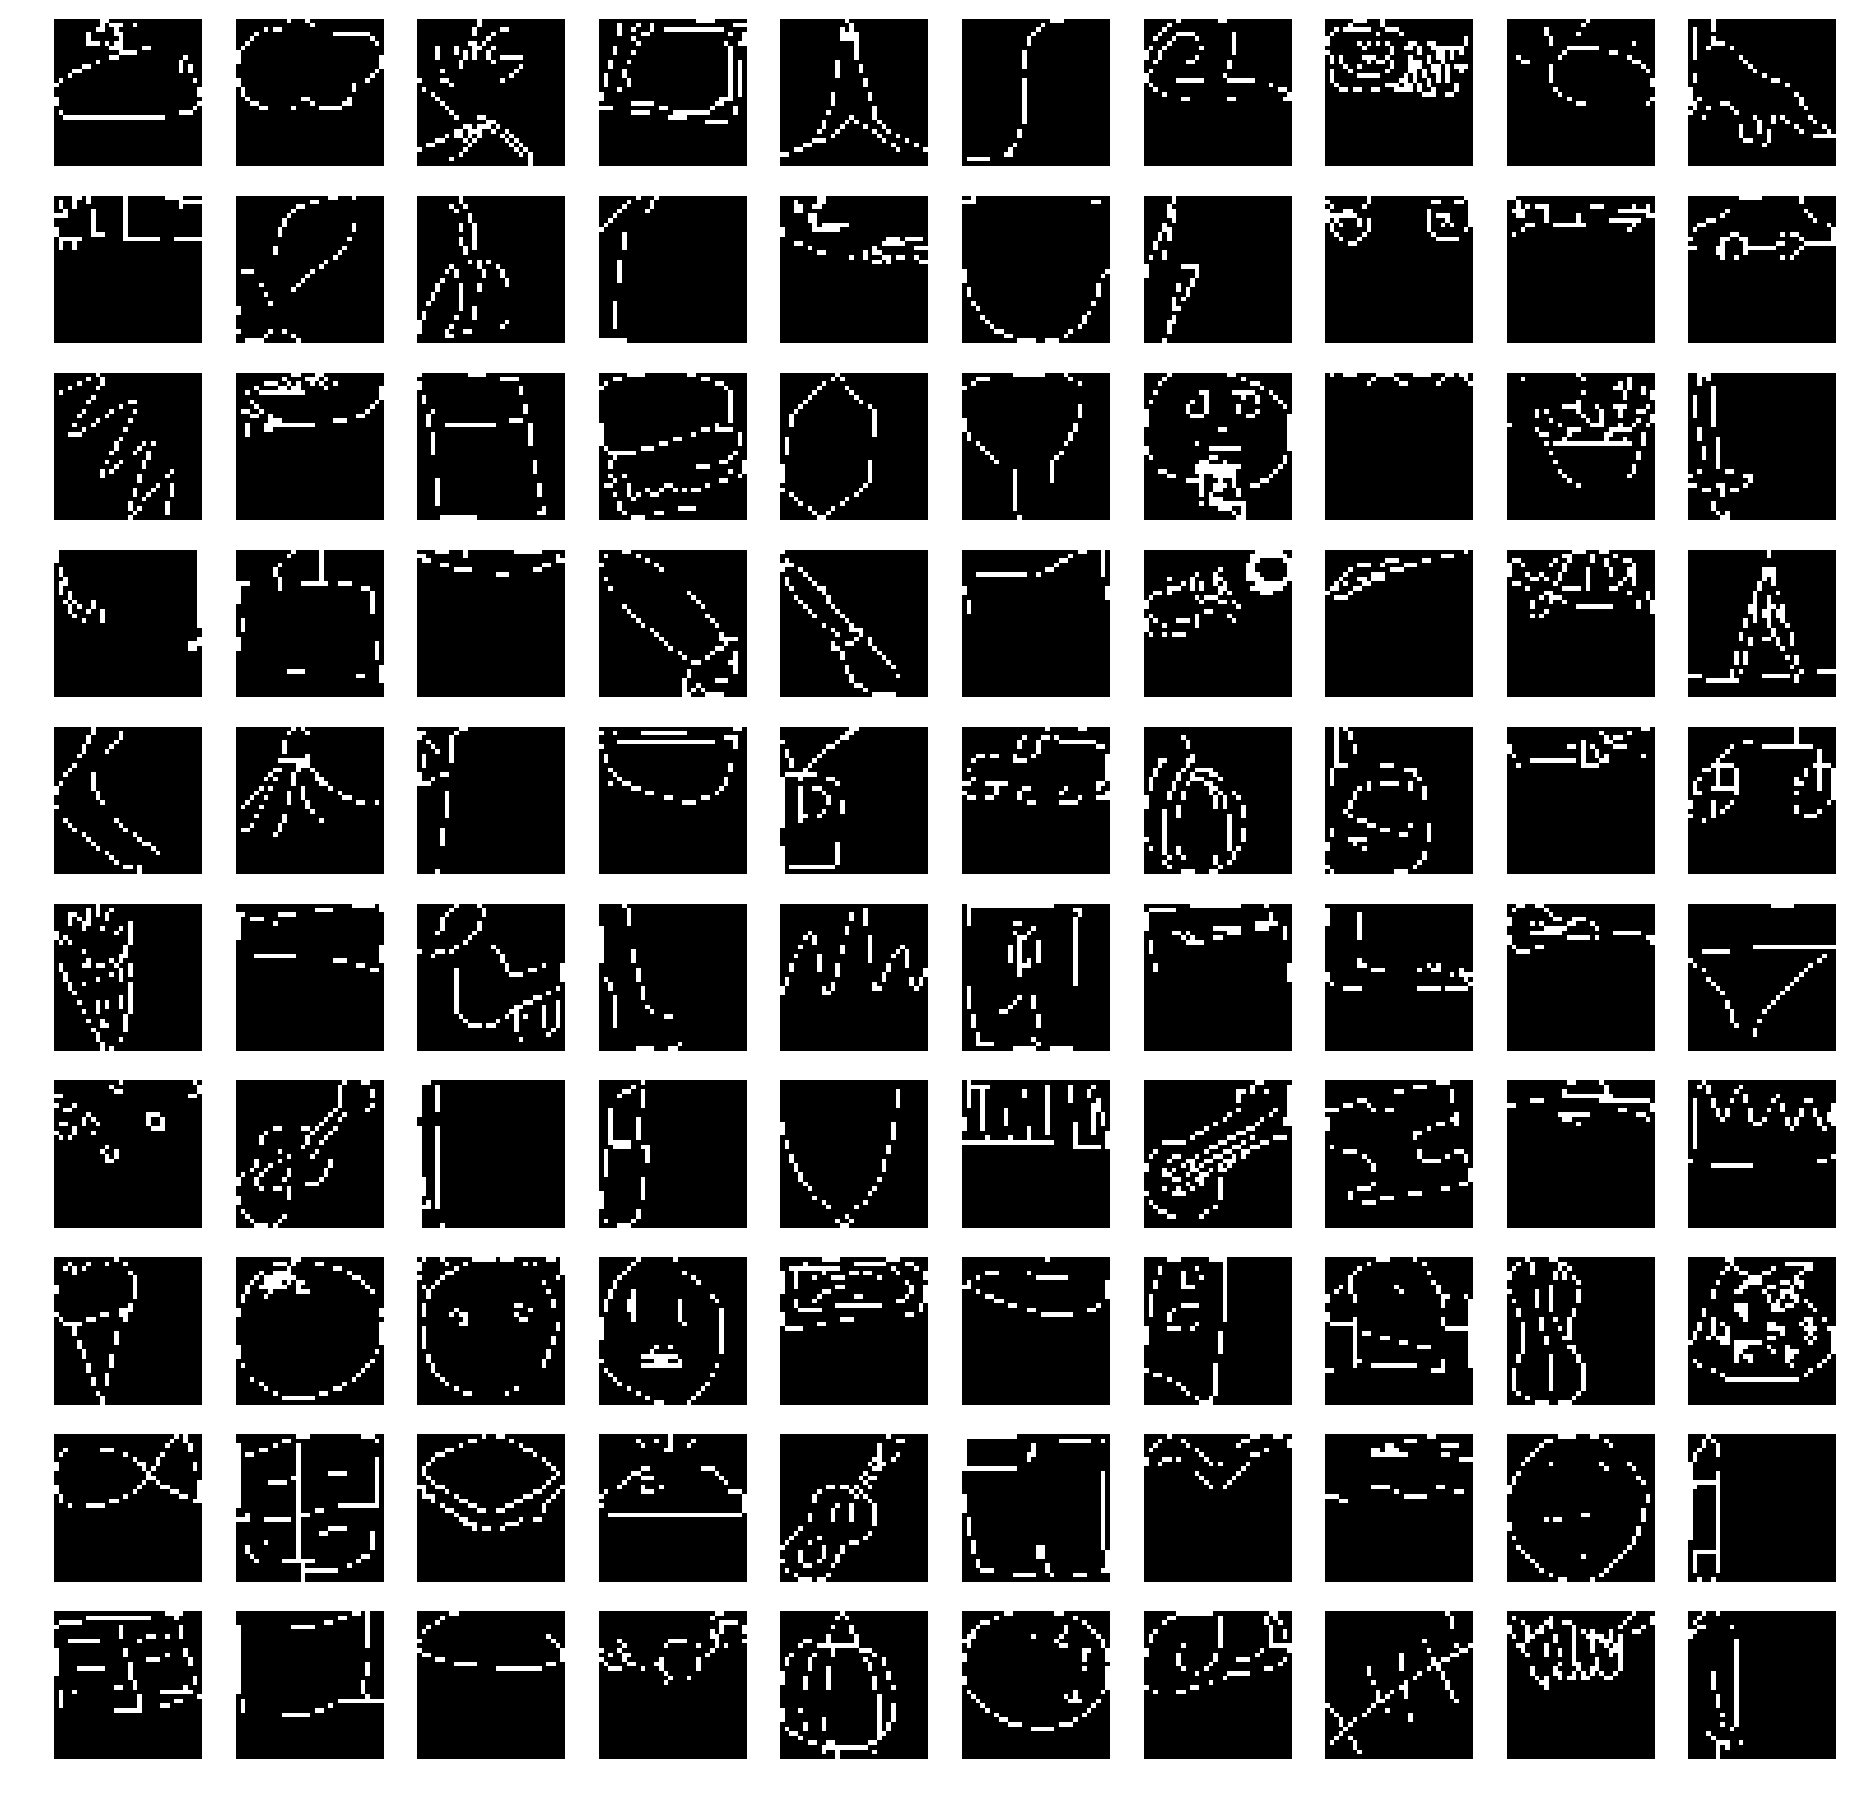

In [31]:
# Print rasterized images
plt.figure(figsize=(16, 16))
for index, image in enumerate(raster_array[:100]):
    plt.subplot(10, 10, index+1)
    plt.gca().invert_yaxis()
    plt.axis("off")
    plt.imshow(image.reshape((IMAGE_SIZE, IMAGE_SIZE)), cmap="binary")

plt.show()

In [27]:
# Split training data for validation
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(raster_array, dummies, test_size=0.2, random_state=13)

In [28]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((1904, 32, 32, 1), (476, 32, 32, 1), (1904, 340), (476, 340))

In [32]:
# Constants
BATCH_SIZE = 64
EPOCHS = 40
NUM_CLASSES = 340
SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 1)
FILTER_SIZE = (4, 4)
PROB_DO_HIDDEN = 0.3

In [33]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation


model = Sequential()
model.add(Conv2D(32, kernel_size=FILTER_SIZE, strides=1, input_shape=SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(PROB_DO_HIDDEN))

model.add(Conv2D(64, kernel_size=FILTER_SIZE, strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(PROB_DO_HIDDEN))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(PROB_DO_HIDDEN))

model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

Using TensorFlow backend.


In [34]:
# Fonte: https://stackoverflow.com/questions/42327006/how-to-calculate-top5-accuracy-in-keras
import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

In [35]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy', top3_acc])

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 29, 29, 32)        544       
_________________________________________________________________
activation_1 (Activation)    (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
__________

In [37]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=int(EPOCHS*0.2))

history = model.fit(train_X, train_label, batch_size=BATCH_SIZE,epochs=EPOCHS,verbose=1,validation_data=(valid_X, valid_label), callbacks=[early_stopping_monitor])

Train on 1904 samples, validate on 476 samples
Epoch 1/40
1904/1904 [==============================] - 2s 1ms/step - loss: 5.8545 - acc: 0.0026 - top3_acc: 0.0079 - val_loss: 5.8314 - val_acc: 0.0000e+00 - val_top3_acc: 0.0000e+00
Epoch 2/40
1904/1904 [==============================] - 0s 190us/step - loss: 5.8288 - acc: 0.0021 - top3_acc: 0.0042 - val_loss: 5.8369 - val_acc: 0.0000e+00 - val_top3_acc: 0.0000e+00
Epoch 3/40
1904/1904 [==============================] - 0s 192us/step - loss: 5.8272 - acc: 0.0032 - top3_acc: 0.0063 - val_loss: 5.8439 - val_acc: 0.0000e+00 - val_top3_acc: 0.0000e+00
Epoch 4/40
1904/1904 [==============================] - 0s 187us/step - loss: 5.8074 - acc: 0.0058 - top3_acc: 0.0142 - val_loss: 5.9277 - val_acc: 0.0000e+00 - val_top3_acc: 0.0021
Epoch 5/40
1904/1904 [==============================] - 0s 188us/step - loss: 5.7003 - acc: 0.0110 - top3_acc: 0.0268 - val_loss: 5.8803 - val_acc: 0.0000e+00 - val_top3_acc: 0.0063
Epoch 6/40
1904/1904 [===========

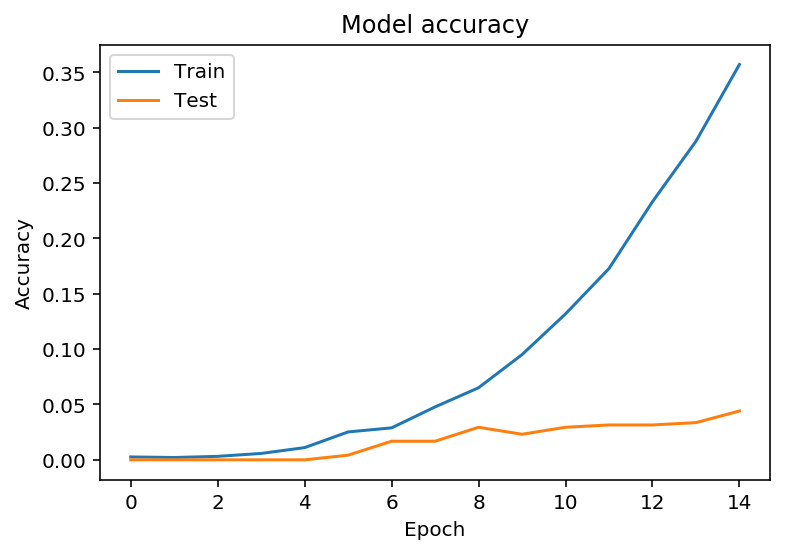

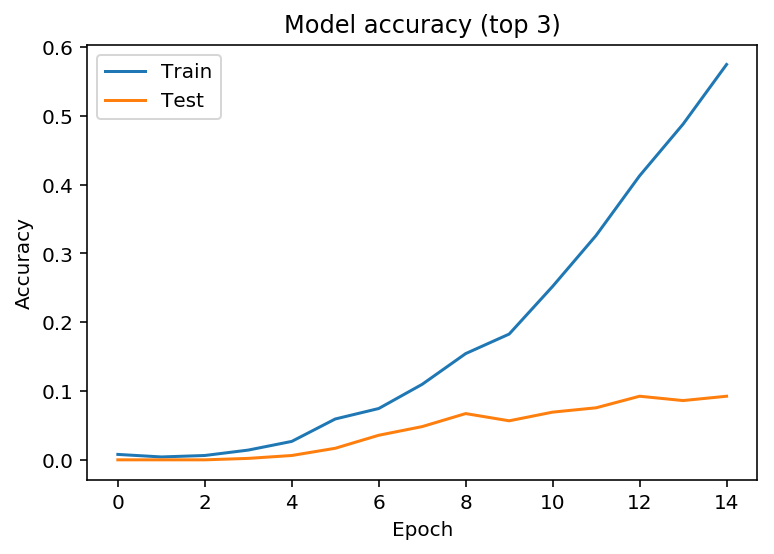

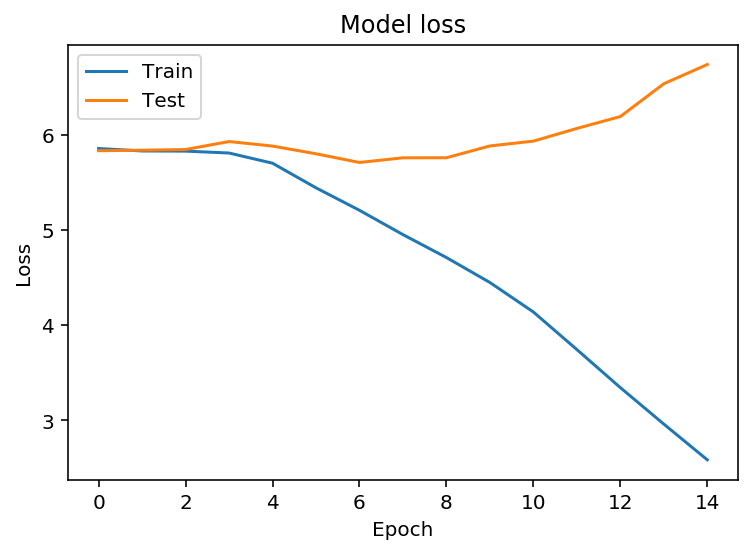

In [38]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['top3_acc'])
plt.plot(history.history['val_top3_acc'])
plt.title('Model accuracy (top 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [39]:
# Predict test dataset with model
test_Y = model.predict(test_X, batch_size=BATCH_SIZE)

In [40]:
# Get top 3 classes
ans = np.argsort(-test_Y)[:,:3]

In [41]:
ans

array([[ 23, 219, 150],
       [265, 243, 219],
       [274, 203, 135],
       ...,
       [195,  45,  90],
       [284, 288,   5],
       [232, 285, 221]])

In [43]:
# Generating output
out_aux = []
for id, i in zip(testidx, dummies.columns[ans]):
    out_aux.append([id, " ".join(map(str, i))])

output = pd.DataFrame(columns=['key_id', 'word'], data=out_aux)

In [44]:
output.head(n=10)

,key_id,word
0,9000003627287624,bathtub piano hospital
1,9000010688666847,sleeping_bag river piano
2,9000023642890129,speedboat oven grass
3,9000038588854897,triangle alarm_clock police_car
4,9000052667981386,The_Eiffel_Tower cello violin
5,9000057427034623,eyeglasses roller_coaster hand
6,9000065506980882,key spoon stethoscope
7,9000087586309806,school_bus train saw
8,9000092580281382,chandelier firetruck The_Eiffel_Tower
9,9000096661653918,spoon hourglass peanut


In [49]:
output.to_csv("submission.csv", index=False)